In this notebook we look at a benchmark approach. In stead of a Reinforcement Learning model, this model will simply use duration matching. 
Looking at the future cashflows it will simply try to best match Assets and Liabilities at each time step, not looking to optimize Net Interest Income.

In [12]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys

# Find the root directory by traversing up the directory tree
def find_project_root(current_path):
    if os.path.exists(os.path.join(current_path, "README.md")):
        return current_path
    parent_path = os.path.dirname(current_path)
    if parent_path == current_path:
        raise ValueError("Project root not found.")
    return find_project_root(parent_path)

current_dir = os.getcwd()
project_root = find_project_root(current_dir)
sys.path.append(str(project_root))
print(f"Project root: {project_root}")

from src.models.bank_env import BankEnv
from src.models.simple_dm import Duration_matching
from src.models.evaluate import evaluate_policy
from src.visualization import visualize
# flake8: noqa  # Disable Flake8 for the following block
import gymnasium as gym

Project root: f:\OneDrive\Documents\GitHub\rl-alm


In [13]:
env_id = "bank-v3"
gym.register(id=env_id, entry_point=BankEnv, max_episode_steps=60)

f:\OneDrive\Documents\GitHub\rl-alm\venv\lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment bank-v3 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [14]:
env = gym.make(env_id, render_mode="human")

2023-11-13 14:37:45.336 | INFO     | src.data.dataset:read_data:45 - reading interest data from ESW.
2023-11-13 14:37:46.958 | INFO     | src.data.dataset:read_data:45 - reading zerocurve data from ESW.


Interest period:  (Timestamp('2010-06-01 00:00:00'), Timestamp('2023-09-01 00:00:00'))
Zerocurve period:  (Timestamp('2010-06-01 00:00:00'), Timestamp('2023-09-01 00:00:00'))


f:\OneDrive\Documents\GitHub\rl-alm\venv\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.bankmodel to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.bankmodel` for environment variables or `env.get_wrapper_attr('bankmodel')` that will search the reminding wrappers.
  logger.warn(
f:\OneDrive\Documents\GitHub\rl-alm\venv\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.list_model to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.list_model` for environment variables or `env.get_wrapper_attr('list_model')` that will search the reminding wrappers.
  logger.warn(
f:\OneDrive\Documents\GitHub\rl-alm\venv\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.list_model to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.list_m

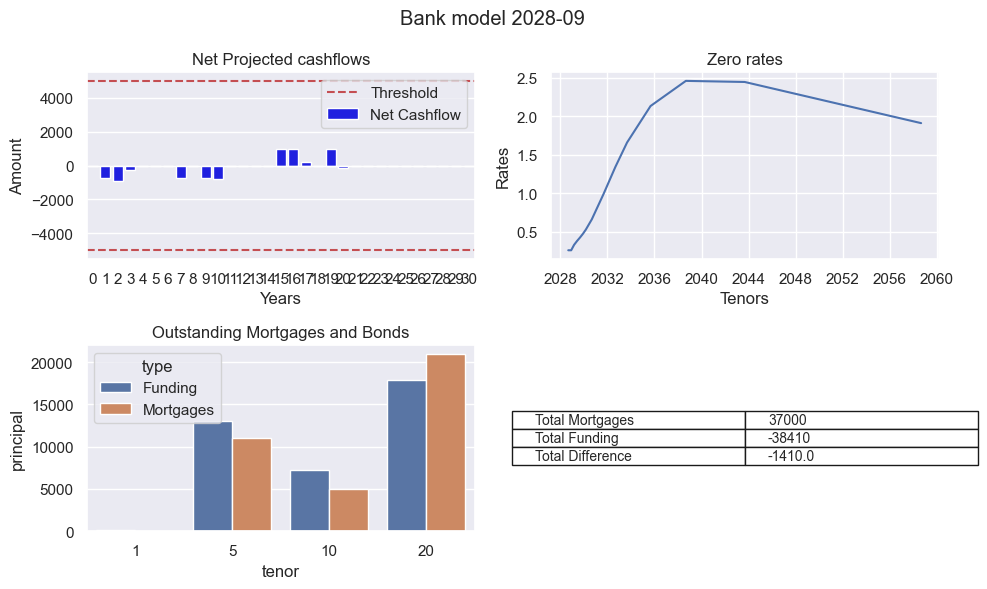

final score:  1196


,timestep,reward,risk_penalty,liquidity_penalty,liquidity,nii,income,funding_cost,total_funding,total_mortgages
0,1,-1,0,0,1652.0,-1,3.727346,-5.459866,-2652,1000
1,2,-1,0,0,1685.0,-1,3.727346,-5.530384,-2685,1000
2,3,0,0,0,685.0,0,6.349778,-5.530384,-2685,2000
3,4,2,0,0,286.0,2,9.072308,-6.764089,-3286,3000
4,5,0,0,0,2537.0,0,12.107437,-12.948305,-6537,4000
5,6,1,0,0,1853.0,1,14.801379,-13.525470,-6853,5000
6,7,3,0,0,1013.0,3,17.775581,-13.844767,-7013,6000
7,8,2,0,0,2013.0,2,17.775581,-15.487867,-8013,6000
8,9,5,0,0,1013.0,5,20.498599,-15.487867,-8013,7000
9,10,5,0,0,1013.0,5,23.296121,-17.478061,-9013,8000


In [19]:

model = Duration_matching(env)

def show_model(env, model) -> int:
    """Show the model in the environment"""        
    # env.set_render_output(modelpath.stem)
    obs, info = env.reset()
    score = 0
    terminated = False
    truncated = False
    # env.set_render_output(model.name)

    while not terminated and not truncated:
        action, _state = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        score = score + reward
        # env.render()
        df = env.list_model()
    env.plot()
    env.close()
    return score, df

score, df = show_model(env, model)
print ('final score: ', score)
display (df)

In [20]:
mean_reward, irq, es, rewards = evaluate_policy(model, env, n_eval_episodes=500)

In [23]:
print(f"number of episodes = {len(rewards)}, mean_reward={mean_reward:.2f} Expected Shortfall={es:.2f} Interquartile Range={irq:.2f}")

number of episodes = 500, mean_reward=1064.02 Expected Shortfall=615.60 Interquartile Range=212.50


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


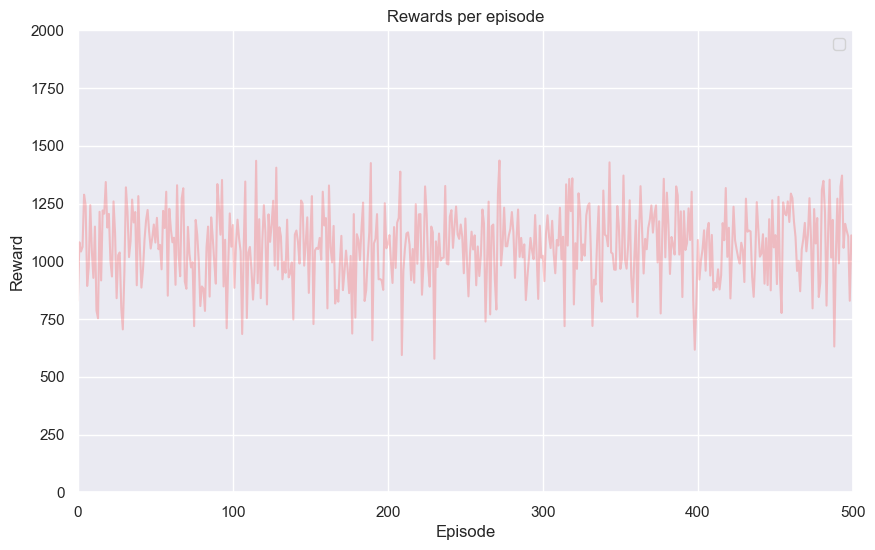

In [22]:
visualize.plot_rewards(rewards, interpolate_line=False, ylim = ((0,2000)))
